# 📧 Detecting Spam Emails Using LSTM

## 📌 Introduction
Email has become one of the most widely used and essential communication tools. However, it comes with the significant rise of spam mail 🚨. Spam messages not only cause inconvenience for users but may also contain harmful content such as phishing attempts 🎣, malware 🦠, or unwanted advertisements 📢. Building an accurate system to detect and classify spam mail is therefore a practical necessity.


- This project focuses on developing a spam mail detection model using Long Short-Term Memory (LSTM) networks 🔗, a powerful architecture for handling sequences and text. Before feeding data into the model, several Natural Language Processing (NLP) techniques ✍️ are applied, including tokenization, stopword removal, text normalization, and embedding, to transform emails into meaningful vector representations.


- A major challenge in spam detection is imbalanced data 📊, since the number of legitimate emails often far exceeds that of spam emails. To address this, the project applies SMOTE (Synthetic Minority Over-sampling Technique) 🧩 to generate synthetic samples for the minority class, allowing the model to learn more effectively and reducing bias during training.

## 🎯 Goal

The goal of this project is to deliver a spam mail detection system with high accuracy , reduced misclassification ❌✔️, and practical applicability in protecting users from unwanted messages and potential threats 🔒.

### 1. Importing all the necessary libraries.

In [ ]:
# !pip install matplotlib

In [ ]:
!pip install imbalanced-learn

In [ ]:
# Importing necessary libraries for EDA.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn
# If nltk is not present then run this command - pip install nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
stopwords.words('english')
import string
string.punctuation
# Importing libraries necessary for Model Building and Training.
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### 2. Loading the data.

In [ ]:
data = pd.read_csv('/content/mail_data.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### 3. Visualize data.

In [ ]:
data['Category'].value_counts()

,count
Category,
0,4825
1,747


In [ ]:
# Mapping 0 -> "ham", 1 -> "spam"
data['Category'] = data['Category'].map({'spam': 1, 'ham': 0})

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_percentage_countplot(data, x, hue):
    """
    Draw a countplot of the percentages of two groups based on the data.

    Parameters:
    - data: DataFrame, the data to plot.
    - x: str, the name of the data column on the x-axis.
    - hue: str, the name of the categorized data column (group).

    Returns:
    None (displays the chart).
    """
    total = float(len(data))  # Total number of observations in the data

    # Draw countplot
    ax = sns.countplot(x=x, hue=hue, data=data, palette = "bright")
    # ax.set_ylabel("Number")

    # Calculate percentage
    for p in ax.patches:
        height = p.get_height()
        if height > 0: # only show if ratio is different from 0%
          ax.text(p.get_x() + p.get_width() / 2.,
                    height / 2 + p.get_y(),
                    '{:.2f}%'.format((height / total) * 100),
                    ha="center",
                    color="white",
                    fontsize=20)

    # Show chart
    plt.show()

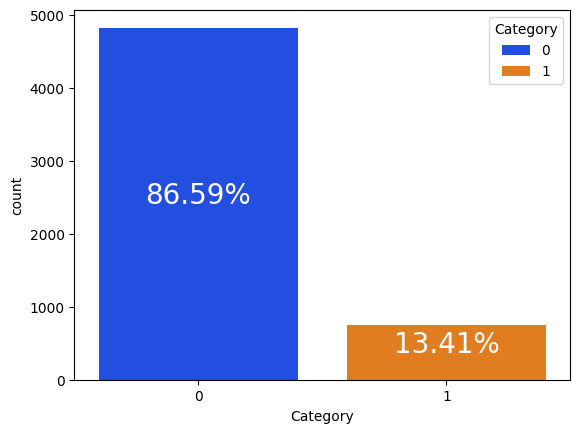

In [ ]:
plot_percentage_countplot(data=data, x='Category', hue='Category')

We can clearly see that the number of Ham samples is more than the number of Spam samples which indicates that the dataset we are using is imbalanced.

### 4. Cleaning Data

#### 4.1. Punctuation

In [ ]:
# Use maketrans to remove punctuation
punctuations_list = string.punctuation

def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

data['Message'] = data['Message'].apply(lambda x: remove_punctuations(x))
data.head()

,Category,Message
0,0,Go until jurong point crazy Available only in ...
1,0,Ok lar Joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor U c already then say
4,0,Nah I dont think he goes to usf he lives aroun...


#### 4.2. Stopword

Are words added to a sentence that do not make it clearer, for example a, an, the, in,..

In [ ]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


data['Message'] = data['Message'].apply(lambda text: remove_stopwords(text))
data.head()

,Category,Message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah dont think goes usf lives around though


In [ ]:
data['Message'] = data['Message'].apply(lambda x: nltk.word_tokenize(x))
data['Word Count'] = data['Message'].apply(lambda x: len(str(x).split()))
data['num_characters'] = data['Message'].apply(lambda x: len(str(x)))

In [ ]:
data

,Category,Message,Word Count,num_characters
0,0,"[go, jurong, point, crazy, available, bugis, n...",16,131
1,0,"[ok, lar, joking, wif, u, oni]",6,42
2,1,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",23,205
3,0,"[u, dun, say, early, hor, u, c, already, say]",9,63
4,0,"[nah, dont, think, goes, usf, lives, around, t...",8,68
...,...,...,...,...
5567,1,"[2nd, time, tried, 2, contact, u, u, £750, pou...",20,172
5568,0,"[ü, b, going, esplanade, fr, home]",6,46
5569,0,"[pity, mood, soany, suggestions]",4,40
5570,0,"[guy, bitching, acted, like, id, interested, b...",14,125


<Axes: xlabel='Word Count', ylabel='Count'>

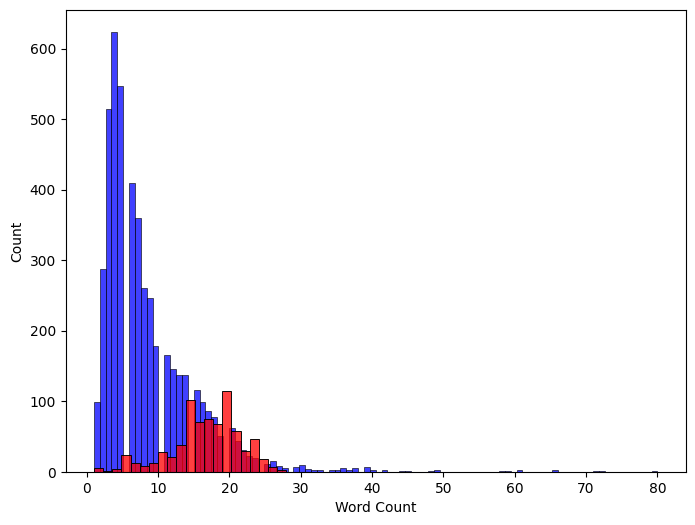

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data[data['Category'] == 0]['Word Count'],color = 'blue')
sns.histplot(data[data['Category'] == 1]['Word Count'],color = 'red')

Here we see that the frequency of group 1 (spam - blue) is less than group 0 (normal - red) and the data are overlapping each other.

<Figure size 800x600 with 0 Axes>

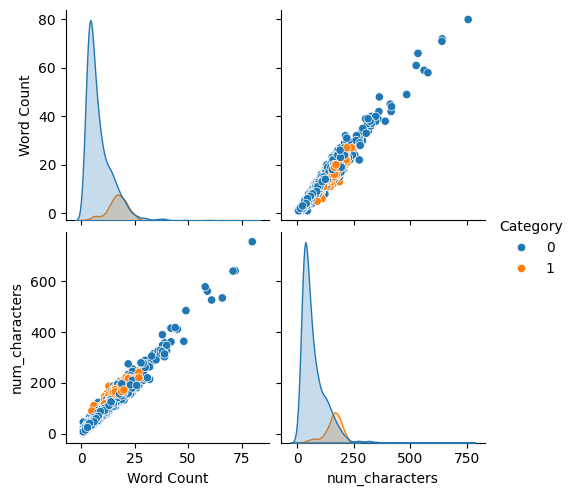

In [ ]:
plt.figure(figsize=(8,6))
sns.pairplot(data,hue='Category')

#### 4.3. PorterStemmer

Change the verb to the infinitive form (remove ed, s, es, ing).

In [ ]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

def remove_stemmer(text):
    stemmer = PorterStemmer()
    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()
        # Apply stemming to each word
        stemmed_word = stemmer.stem(word)
        imp_words.append(stemmed_word)

    output = " ".join(imp_words)

    return output


data['Message'] = data['Message'].apply(lambda text: remove_stemmer(text))
data['Message']

,Message
0,"['go', 'jurong', 'point', 'crazy', 'available'..."
1,"['ok', 'lar', 'joking', 'wif', 'u', 'oni']"
2,"['free', 'entry', '2', 'wkly', 'comp', 'win', ..."
3,"['u', 'dun', 'say', 'early', 'hor', 'u', 'c', ..."
4,"['nah', 'dont', 'think', 'goes', 'usf', 'lives..."
...,...
5567,"['2nd', 'time', 'tried', '2', 'contact', 'u', ..."
5568,"['ü', 'b', 'going', 'esplanade', 'fr', 'home']"
5569,"['pity', 'mood', 'soany', 'suggestions']"
5570,"['guy', 'bitching', 'acted', 'like', 'id', 'in..."


We spend 80% of the data set to train the learning model and keep 20% for testing, this 20% of data will not be revealed, not peeked for the purpose of seeing how well the model works.

### 5. POS tagging

It shows what type of word it is (noun, adjective, verb, etc.)

In [ ]:
import ast
import spacy

# Download Spacy model (assume you have downloaded 'en_core_web_sm' or similar)
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Please run: python -m spacy download en_core_web_sm")

def safe_str_to_list(text_str):
    """
    Convert the string in the form of "token1", 'token2', ... "into list ['token1', 'token2', ...].
    Use AST.Literal_eval safer.
    If it fails, assuming it is a normal string and split by distance.
    """
    try:
        # Pythonic chain processing (as shown in your picture)
        # Eliminate [] at both ends if any and syntax handling
        if text_str.startswith('[') and text_str.endswith(']'):
            return ast.literal_eval(text_str)
        # If only a regular string has a comma:
        return [item.strip().strip("'") for item in text_str.split(',')]
    except:
        # If it's just a string that has been separated by spaces
        return text_str.split()

# Application of formatting error correction function
print("Converting column 'Message' from string to List of Tokens...")
data['Message_Tokens'] = data['Message'].apply(safe_str_to_list)

Converting column 'Message' from string to List of Tokens...


In [ ]:
def get_pos_tags(token_list):
    """
    Get list of tokens, connect them, and process with Spacy.
    """
    # Connect the money token to be processed into one sentence
    sentence = " ".join(token_list)

    # Process the sentence
    doc = nlp(sentence)

    # Extraction of pair (token.text, token.pos_)
    # Note: Spacy can still create unwanted tokens (for example, sentence marks)
    # However, this is the best way for Spacy to receive context.
    return [(token.text, token.pos_) for token in doc]

# --- 3. Apply the error correction function ---
print("Start POS Tagging on the corrected message ...")
# Apply the GET_POS_TAGS function to the column fixed the format error: 'Message_tokens'
data['POS_Tags'] = data['Message_Tokens'].apply(get_pos_tags)
print("Complete POS Tagging.")

# To ensure consistency with the model, you need to consider the next step:
# If you want to add POS Tags to the model, you will have to create new tokens:
# Example: "Go_verb", "Jurong_noun", ...

Start POS Tagging on the corrected message ...
Complete POS Tagging.


In [ ]:
data

,Category,Message,Word Count,num_characters,Message_Tokens,POS_Tags
0,0,"['go', 'jurong', 'point', 'crazy', 'available'...",16,131,"[go, jurong, point, crazy, available, bugis, n...","[(go, VERB), (jurong, PROPN), (point, NOUN), (..."
1,0,"['ok', 'lar', 'joking', 'wif', 'u', 'oni']",6,42,"[ok, lar, joking, wif, u, oni]","[(ok, INTJ), (lar, ADJ), (joking, NOUN), (wif,..."
2,1,"['free', 'entry', '2', 'wkly', 'comp', 'win', ...",23,205,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","[(free, ADJ), (entry, NOUN), (2, NUM), (wkly, ..."
3,0,"['u', 'dun', 'say', 'early', 'hor', 'u', 'c', ...",9,63,"[u, dun, say, early, hor, u, c, already, say]","[(u, PRON), (dun, PROPN), (say, VERB), (early,..."
4,0,"['nah', 'dont', 'think', 'goes', 'usf', 'lives...",8,68,"[nah, dont, think, goes, usf, lives, around, t...","[(nah, INTJ), (do, AUX), (nt, PART), (think, V..."
...,...,...,...,...,...,...
5567,1,"['2nd', 'time', 'tried', '2', 'contact', 'u', ...",20,172,"[2nd, time, tried, 2, contact, u, u, £750, pou...","[(2nd, ADJ), (time, NOUN), (tried, VERB), (2, ..."
5568,0,"['ü', 'b', 'going', 'esplanade', 'fr', 'home']",6,46,"[ü, b, going, esplanade, fr, home]","[(ü, PROPN), (b, ADP), (going, VERB), (esplana..."
5569,0,"['pity', 'mood', 'soany', 'suggestions']",4,40,"[pity, mood, soany, suggestions]","[(pity, NOUN), (mood, NOUN), (soany, ADJ), (su..."
5570,0,"['guy', 'bitching', 'acted', 'like', 'id', 'in...",14,125,"[guy, bitching, acted, like, id, interested, b...","[(guy, NOUN), (bitching, NOUN), (acted, VERB),..."


In [ ]:
# Note: The POS labels of spaCy and NLTK are slightly different, we need to remap.
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from imblearn.over_sampling import SMOTE # Import SMOTE
from sklearn.model_selection import train_test_split # Import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer # Import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import pad_sequences

# Download wordnet if not already present
try:
    nltk.data.find('corpora/wordnet')
except LookupError as e:
    print(f"NLTK resource 'wordnet' not found. Downloading...")
    nltk.download('wordnet')


lemmatizer = WordNetLemmatizer()
# --- POS Tag Mapping Function (From spaCy/Universal to WordNet) ---
def get_wordnet_pos(treebank_tag):
    """Map Universal/spaCy POS tags to WordNetLemmatizer format."""
    if treebank_tag.startswith('ADJ'):
        return wordnet.ADJ
    elif treebank_tag.startswith('VERB') or treebank_tag.startswith('AUX'):
        return wordnet.VERB
    elif treebank_tag.startswith('NOUN') or treebank_tag.startswith('PROPN'):
        return wordnet.NOUN
    elif treebank_tag.startswith('ADV'):
        return wordnet.ADV
    return wordnet.NOUN # Default is Noun

# --- Use POS Tag to perform Accurate Lemmatization ---
def accurate_lemmatization(pos_tags_list):
    lemmatized_tokens = []
    # Ensure the input is treated as a string representation of a list
    # Safely evaluate the string as a list if it's not already a list
    if isinstance(pos_tags_list, str):
      try:
          # Attempt to evaluate the string as a list of tuples
          pos_tags_list = eval(pos_tags_list)
      except:
          # If evaluation fails, return an empty string or handle as needed
          return ""
    elif not isinstance(pos_tags_list, list):
         return ""


    lemmatized_tokens = []
    for token, tag in pos_tags_list:
        # Tag mapping
        wn_tag = get_wordnet_pos(tag)

        # Lemmatize
        lemma = lemmatizer.lemmatize(token, wn_tag)
        lemmatized_tokens.append(lemma)

    # Concatenate into Lemmatized text string
    return " ".join(lemmatized_tokens)

print("--- 1. Lemmatization ---")
data['Lemmatized_Text'] = data['POS_Tags'].apply(accurate_lemmatization)
print(data[['Message', 'Lemmatized_Text']].head())

NLTK resource 'wordnet' not found. Downloading...
--- 1. Lemmatization ---


[nltk_data] Downloading package wordnet to /root/nltk_data...


                                             Message  \
0  ['go', 'jurong', 'point', 'crazy', 'available'...   
1         ['ok', 'lar', 'joking', 'wif', 'u', 'oni']   
2  ['free', 'entry', '2', 'wkly', 'comp', 'win', ...   
3  ['u', 'dun', 'say', 'early', 'hor', 'u', 'c', ...   
4  ['nah', 'dont', 'think', 'goes', 'usf', 'lives...   

                                     Lemmatized_Text  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry 2 wkly comp win fa cup final tkts 2...  
3                u dun say early hor u c already say  
4          nah do nt think go usf life around though  


### 6. Split the dataset via train_test_split

In [ ]:
# Split original data
X = data['Lemmatized_Text'] # Using Lemmatized Text
y = data['Category']

# Split data: 80% Train, 20% Test (stratify=y to keep the ratio)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Initial Train label distribution:\n{y_train.value_counts()}")

Initial Train label distribution:
Category
0    3859
1     598
Name: count, dtype: int64


### 7. Vectorization & Padding

In [ ]:
# Vectorization and Padding for LSTM
max_words = 5000
maxlen = 20 # Limit the max length to 20 words (example)

# Initialize and train Tokenizer on TRAIN SET only
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train_raw)

# Convert text to numeric string
X_train_sequences = tokenizer.texts_to_sequences(X_train_raw)
X_test_sequences = tokenizer.texts_to_sequences(X_test_raw)

# Padding (normalize length)
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')
print(f"X_train size after Padding: {X_train_padded.shape}")

X_train size after Padding: (4457, 20)


In [ ]:
print(data['Lemmatized_Text'].head())
print(type(data['Lemmatized_Text'].iloc[0]))

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                  u dun say early hor u c already say
4            nah do nt think go usf life around though
Name: Lemmatized_Text, dtype: object
<class 'str'>


### 8. SMOTE

SMOTE is a more advanced technique than regular upsampling. Instead of simply copying existing spam samples, SMOTE creates new, synthetic samples from adjacent samples. This helps the model learn common features of the minority (spam) class without having to “memorize” old samples, thereby reducing the risk of overfitting.

In [ ]:
# Handling Imbalanced Data (SMOTE on Train Set)
# X_train_padded data is already a numeric matrix, valid for SMOTE

print("--- Apply SMOTE on Train Set ---")
smote = SMOTE(random_state=42)

# SMOTE works best on encoded/vectorized data
X_train_smote, y_train_smote = smote.fit_resample(X_train_padded, y_train)

print(f"Train Label Distribution AFTER SMOTE:\n{y_train_smote.value_counts()}")
print(f"Balanced Train Set Size (SMOTE): {X_train_smote.shape}")

# Data ready for LSTM model:
# X_train_smote, y_train_smote
# X_test_padded, y_test
# 4457 emails including spam and ham after Padding
# every email in the training set has been normalized to length 20 (by truncating or inserting zeros)
# 3859(ham) − 598(spam) = 3261 new synthetic Spam samples
# Your new training set is now perfectly balanced with 7718 samples.

--- Apply SMOTE on Train Set ---
Train Label Distribution AFTER SMOTE:
Category
0    3859
1    3859
Name: count, dtype: int64
Balanced Train Set Size (SMOTE): (7718, 20)


### 9. LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

# 1. Set up the model parameters
# These parameters have been defined in the previous steps:
max_words = 5000 # Maximum vocabulary
maxlen = 20 # Maximum sequence length
embedding_dim = 100 # Embedding vector size (optional, 50-300 is common)

# 2. Build the LSTM Model
print("--- Build the LSTM Model ---")
model = Sequential()

# Embedding layer: Convert the word indices (numbers) into dense vectors (dense vectors)
model.add(Embedding(
        input_dim=max_words, # Vocabulary size
        output_dim=embedding_dim, # Embedding vector size
        input_length=maxlen # Sequence input length
          ))

# LSTM layer: Core layer to learn sequential relationships
model.add(LSTM(units=128, return_sequences=False)) # return_sequences=False as this is the last layer before Dense

# Dropout layer: Reduce overfitting
model.add(Dropout(0.5))

# Dense layer (Output): A single node (as this is a binary classification: Ham/Spam)
# Activate 'sigmoid' for probability output
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(
  optimizer='adam',
  loss='binary_crossentropy', # Suitable for binary classification
  metrics=['accuracy']
)

model.summary()

--- Build the LSTM Model ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train Model
print("--- Start Model Training ---")
# Use SMOTE-Balanced data
history = model.fit(
            X_train_smote,
            y_train_smote,
            epochs=10, # Test with 10 epochs
            batch_size=32,
            validation_split=0.1, # Split 10% of the training set (SMOTE) to test validation
            verbose=1
          )
print("Training complete.")

--- Start Model Training ---
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8019 - loss: 0.4128 - val_accuracy: 0.8394 - val_loss: 0.4112
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9468 - loss: 0.1694 - val_accuracy: 0.8808 - val_loss: 0.3096
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9693 - loss: 0.1042 - val_accuracy: 0.8977 - val_loss: 0.2851
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9765 - loss: 0.0829 - val_accuracy: 0.8808 - val_loss: 0.3307
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9866 - loss: 0.0474 - val_accuracy: 0.8601 - val_loss: 0.3183
Epoch 6/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9871 - loss: 0.0446 - val_accuracy: 0.8705 - val_loss: 0.4158
Epoch 7/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9897 - loss: 0.0338 - val_accuracy: 0.8860 - val_loss: 0.4310
Epoch 8/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 

### 10. Evaluation.

In [ ]:
# Evaluate Model on ORIGINAL Test Set (No SMOTE)
print("--- Evaluate on ORIGINAL Test Set ---")
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"Accuracy on Test Set: {accuracy:.4f}")

# Predict and print Classification Report
y_pred_prob = model.predict(X_test_padded)
# Convert probability to binary label (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

--- Evaluate on ORIGINAL Test Set ---
Accuracy on Test Set: 0.9668
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       966
           1       0.85      0.92      0.88       149

    accuracy                           0.97      1115
   macro avg       0.92      0.95      0.93      1115
weighted avg       0.97      0.97      0.97      1115


Confusion Matrix:
[[941  25]
 [ 12 137]]


### 11. Test on a new dataset

In [ ]:
# Test on 10 New Sentences
new_test_emails = [
    "You have won a FREE lottery prize of $1000! Click here to claim your cash now.", # Spam rõ ràng
    "Dear team, please review the Q3 report and provide feedback by end of day.", # Ham rõ ràng
    "URGENT: Your account has been suspended. Verify your bank details immediately to reactivate.", # Spam (Giả mạo phishing)
    "Hello John, what time should we meet tomorrow for lunch?", # Ham
    "Congratulations! Claim your free gift card by texting YES to 8765. Offer expires today.", # Spam
    "The weather forecast shows rain tomorrow, so bring an umbrella.", # Ham
    "Re: Project proposal update, attached is the revised document.", # Ham
    "Get rich quick! Invest in our amazing, new crypto opportunity today.", # Spam
    "I'm running a little late, please start the meeting without me.", # Ham
    "Last chance to enter our competition and win a brand new car for only $1." # Spam
]

# Prepare new test data following the same procedure:
# 1. Tokenizer
new_sequences = tokenizer.texts_to_sequences(new_test_emails)
# 2. Padding
new_padded = pad_sequences(new_sequences, maxlen=maxlen, padding='post')

# Forecast
new_predictions_prob = model.predict(new_padded)
new_predictions = (new_predictions_prob > 0.5).astype(int)

print("--- Prediction Results on 10 New Questions ---")
results = []
for email, prob, pred in zip(new_test_emails, new_predictions_prob, new_predictions):
    label = "SPAM" if pred[0] == 1 else "HAM"
    results.append({
        "Email": email,
        "Predict": label,
        "Spam Probability": f"{prob[0]:.4f}"
    })

results_df = pd.DataFrame(results)
print(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
--- Prediction Results on 10 New Questions ---
                                               Email Predict Spam Probability
0  You have won a FREE lottery prize of $1000! Cl...    SPAM           1.0000
1  Dear team, please review the Q3 report and pro...     HAM           0.0008
2  URGENT: Your account has been suspended. Verif...    SPAM           0.9792
3  Hello John, what time should we meet tomorrow ...     HAM           0.0013
4  Congratulations! Claim your free gift card by ...    SPAM           0.9998
5  The weather forecast shows rain tomorrow, so b...     HAM           0.0010
6  Re: Project proposal update, attached is the r...     HAM           0.0009
7  Get rich quick! Invest in our amazing, new cry...     HAM           0.0022
8  I'm running a little late, please start the me...     HAM           0.1472
9  Last chance to enter our competition and win a...    SPAM           0.9996


Linear SVC (Error: Line 8): Causes False Negative (FN) error - Misses Spam.